In [11]:
library("gRain")
library("Rgraphviz")
#library("dagitty")
library("bnlearn")
library("pcalg")
library("dplyr")

In [4]:
#setwd("/Users/lisa/Documents/Uni/03.SemesterMaster/BN/bn17")
setwd("/Users/kai/Dropbox/Uni/Nijmegen/WS17_18/BN")
d <- read.table(header=T, sep=",", 'adult_cleaned.csv')
d[d=="?"]<-NA
d <- d[complete.cases(d),]
d <- data.frame(d)

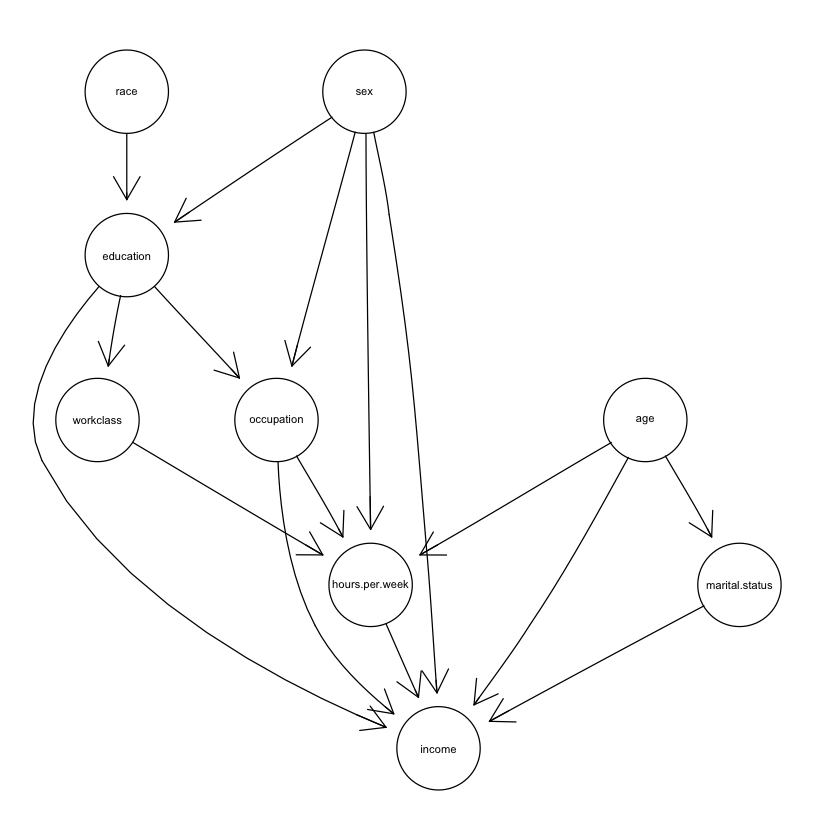

In [6]:
our_network <- dag(~ race + education:race:sex + workclass:education + hours.per.week:workclass:occupation:age:sex + occupation:education:sex + marital.status:age + income:age:sex:occupation:hours.per.week:education:marital.status)
plot(our_network)

In [7]:
## Load data
V <- colnames(d)

In [8]:
# age 8
# workclass 7
# education 6
# marital.status 7
# occupation 6
# race 5
# sex 2
# hours.per.week 6
# native.country 2
# income 2

In [9]:
## define sufficient statistics
suffStat <- list(dm = d, nlev = c(8,7,6,7,6,5,2,6,2,2), adaptDF = FALSE)

In [10]:
## estimate CPDAG
pc.D <- pc(suffStat,
           ## independence test: G^2 statistic
           indepTest = disCItest, alpha = 0.01, labels = V, verbose = TRUE)

Order=0; remaining edges:90
x= 1  y= 2  S=  : pval = 0 
x= 1  y= 3  S=  : pval = 0 
x= 1  y= 4  S=  : pval = 0 
x= 1  y= 5  S=  : pval = 1.003792e-190 
x= 1  y= 6  S=  : pval = 4.206252e-11 
x= 1  y= 7  S=  : pval = 1.196726e-77 
x= 1  y= 8  S=  : pval = 0 
x= 1  y= 9  S=  : pval = 2.699078e-11 
x= 1  y= 10  S=  : pval = 0 
x= 2  y= 1  S=  : pval = 0 
x= 2  y= 3  S=  : pval = 3.31886e-249 
x= 2  y= 4  S=  : pval = 2.450515e-213 
x= 2  y= 5  S=  : pval = 0 
x= 2  y= 6  S=  : pval = 2.320825e-77 
x= 2  y= 7  S=  : pval = 2.244287e-151 
x= 2  y= 8  S=  : pval = 0 
x= 2  y= 9  S=  : pval = 6.724318e-18 
x= 2  y= 10  S=  : pval = 3.200481e-151 
x= 3  y= 1  S=  : pval = 0 
x= 3  y= 2  S=  : pval = 3.31886e-249 
x= 3  y= 4  S=  : pval = 7.361269e-101 
x= 3  y= 5  S=  : pval = 0 
x= 3  y= 6  S=  : pval = 4.170315e-51 
x= 3  y= 7  S=  : pval = 5.471693e-28 
x= 3  y= 8  S=  : pval = 2.712991e-146 
x= 3  y= 9  S=  : pval = 2.782778e-235 
x= 3  y= 10  S=  : pval = 0 
x= 4  y= 1  S=  : pval = 0 
x=

Warning message in gSquareDis(x = x, y = y, S = S, dm = dm, nlev = nlev, adaptDF = adaptDF, :
“n=30162 is too small (n < n.min = 30240 ) for G^2 test (=> treated as independence)”

x= 1  y= 4  S= 3 8 10 : pval = 1 
x= 1  y= 8  S= 3 4 10 : pval = 8.924022e-37 
x= 1  y= 10  S= 3 4 8 : pval = 1 
x= 2  y= 5  S= 7 8 10 : pval = 0 
x= 2  y= 7  S= 5 8 10 : pval = 2.015939e-42 
x= 2  y= 8  S= 5 7 10 : pval = 7.75569e-162 
x= 2  y= 10  S= 5 7 8 : pval = 6.839356e-16 
x= 3  y= 5  S= 1 9 10 : pval = 0 
x= 3  y= 9  S= 1 5 10 : pval = 7.214369e-100 
x= 3  y= 10  S= 1 5 9 : pval = 1.935001e-69 
x= 4  y= 7  S= 1 8 9 : pval = 0 
x= 4  y= 7  S= 1 8 10 : pval = 0 
x= 4  y= 7  S= 1 9 10 : pval = 0 
x= 4  y= 7  S= 8 9 10 : pval = 0 
x= 4  y= 8  S= 1 7 9 : pval = 1.477433e-13 
x= 4  y= 8  S= 1 7 10 : pval = 1.866253e-08 
x= 4  y= 8  S= 1 9 10 : pval = 1.892599e-12 
x= 4  y= 8  S= 7 9 10 : pval = 2.966865e-180 
x= 4  y= 9  S= 1 7 8 : pval = 0.0003694809 
x= 4  y= 9  S= 1 7 10 : pval = 2.181924e-25 
x= 4  y= 9  S= 1 8 10 : pval = 0.02371447 
x= 4  y= 10  S= 1 7 8 : pval = 0 
x= 4  y= 10  S= 1 7 9 : pval = 0 
x= 4  y= 10  S= 1 8 9 : pval = 0 
x= 4  y= 10  S= 7 8 9 : pval = 0 
x= 5  y= 2

Warning message in gSquareDis(x = x, y = y, S = S, dm = dm, nlev = nlev, adaptDF = adaptDF, :
“n=30162 is too small (n < n.min = 102900 ) for G^2 test (=> treated as independence)”

x= 8  y= 1  S= 2 4 5 : pval = 1 


Warning message in gSquareDis(x = x, y = y, S = S, dm = dm, nlev = nlev, adaptDF = adaptDF, :
“n=30162 is too small (n < n.min = 100800 ) for G^2 test (=> treated as independence)”

x= 8  y= 2  S= 1 4 5 : pval = 1 


Warning message in gSquareDis(x = x, y = y, S = S, dm = dm, nlev = nlev, adaptDF = adaptDF, :
“n=30162 is too small (n < n.min = 100800 ) for G^2 test (=> treated as independence)”

x= 8  y= 4  S= 1 2 5 : pval = 1 


Warning message in gSquareDis(x = x, y = y, S = S, dm = dm, nlev = nlev, adaptDF = adaptDF, :
“n=30162 is too small (n < n.min = 98000 ) for G^2 test (=> treated as independence)”

x= 8  y= 5  S= 1 2 4 : pval = 1 
x= 8  y= 7  S= 1 2 4 : pval = 0.2664647 
x= 8  y= 10  S= 1 2 4 : pval = 1 
x= 10  y= 2  S= 1 3 4 : pval = 1 
x= 10  y= 3  S= 1 2 4 : pval = 1.286812e-10 
x= 10  y= 3  S= 1 2 5 : pval = 0.9755598 
x= 10  y= 4  S= 1 2 3 : pval = 2.936141e-243 
x= 10  y= 4  S= 1 2 5 : pval = 8.65925e-299 
x= 10  y= 4  S= 1 2 7 : pval = 0 
x= 10  y= 4  S= 1 2 8 : pval = 6.378931e-202 
x= 10  y= 4  S= 1 3 5 : pval = 0 
x= 10  y= 4  S= 1 3 7 : pval = 0 
x= 10  y= 4  S= 1 3 8 : pval = 3.93375e-256 
x= 10  y= 4  S= 1 5 7 : pval = 0 
x= 10  y= 4  S= 1 5 8 : pval = 0 
x= 10  y= 4  S= 1 7 8 : pval = 0 
x= 10  y= 4  S= 2 3 5 : pval = 0 
x= 10  y= 4  S= 2 3 7 : pval = 0 
x= 10  y= 4  S= 2 3 8 : pval = 0 
x= 10  y= 4  S= 2 5 7 : pval = 0 
x= 10  y= 4  S= 2 5 8 : pval = 0 
x= 10  y= 4  S= 2 7 8 : pval = 0 
x= 10  y= 4  S= 3 5 7 : pval = 0 
x= 10  y= 4  S= 3 5 8 : pval = 0 
x= 10  y= 4  S= 3 7 8 : pval = 0 
x= 10  y= 4  S= 5 7 8 : pval = 0 
Order=4; remaining edges:14


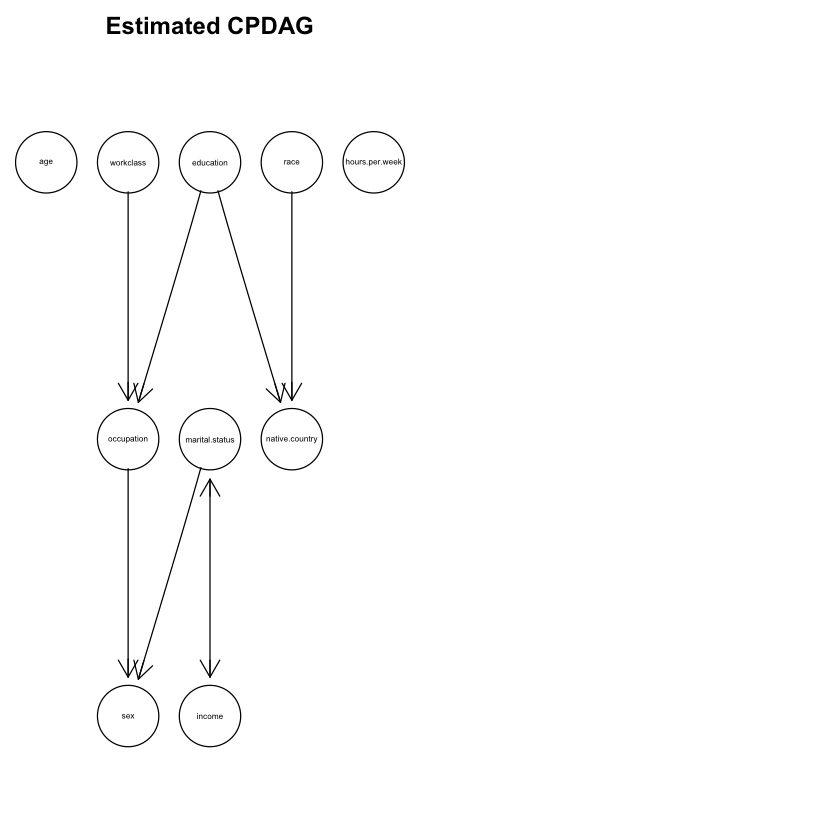

In [12]:
if (require(Rgraphviz)) {
  ## show estimated CPDAG
  par(mfrow = c(1,2))
  plot(pc.D, main = "Estimated CPDAG")
}

In [13]:
data(learning.test)

In [22]:
head(learning.test)
typeof(learning.test[[1]][1])

A,B,C,D,E,F
b,c,b,a,b,b
b,a,c,a,b,b
a,a,a,a,a,a
a,a,a,a,b,b
a,a,b,c,a,a
c,c,a,c,c,a


[1] "integer"

In [33]:
head(d)

age,workclass,education,marital.status,occupation,race,sex,hours.per.week,native.country,income
2,5,2,2,0,0,0,3,0,0
3,1,2,0,0,0,0,0,0,0
2,0,2,1,1,0,0,3,0,0
4,0,1,0,1,4,0,3,0,0
1,0,2,0,3,4,1,3,1,0
2,0,3,0,0,0,1,3,0,0


In [39]:
d$age <- as.ordered(d$age)
d$workclass <- as.factor(d$workclass)
d$education <- as.factor(d$education)
d$marital.status <- as.factor(d$marital.status)
d$occupation <- as.factor(d$occupation)
d$race <- as.factor(d$race)
d$sex <- as.factor(d$sex)
d$hours.per.week <- as.ordered(d$hours.per.week)
d$native.country <- as.factor(d$native.country)
d$income <- as.ordered(d$income)

Warning message in check.score(score, x):
“no score is available for ordinal data, disregarding the ordering of the levels.”


  Bayesian network learned via Hybrid methods

  model:
   [age][race][hours.per.week][education|age][marital.status|age]
   [native.country|race][sex|marital.status][income|marital.status]
   [occupation|education:sex][workclass|occupation]
  nodes:                                 10 
  arcs:                                  8 
    undirected arcs:                     0 
    directed arcs:                       8 
  average markov blanket size:           1.80 
  average neighbourhood size:            1.60 
  average branching factor:              0.80 

  learning algorithm:                    Max-Min Hill-Climbing 
  constraint-based method:               Max-Min Parent Children 
  conditional independence test:         Mutual Information (disc.) 
  score-based method:                    Hill-Climbing 
  score:                                 BIC (disc.) 
  alpha threshold:                       0.05 
  penalization coefficient:              5.157169 
  tests used in the learning pr

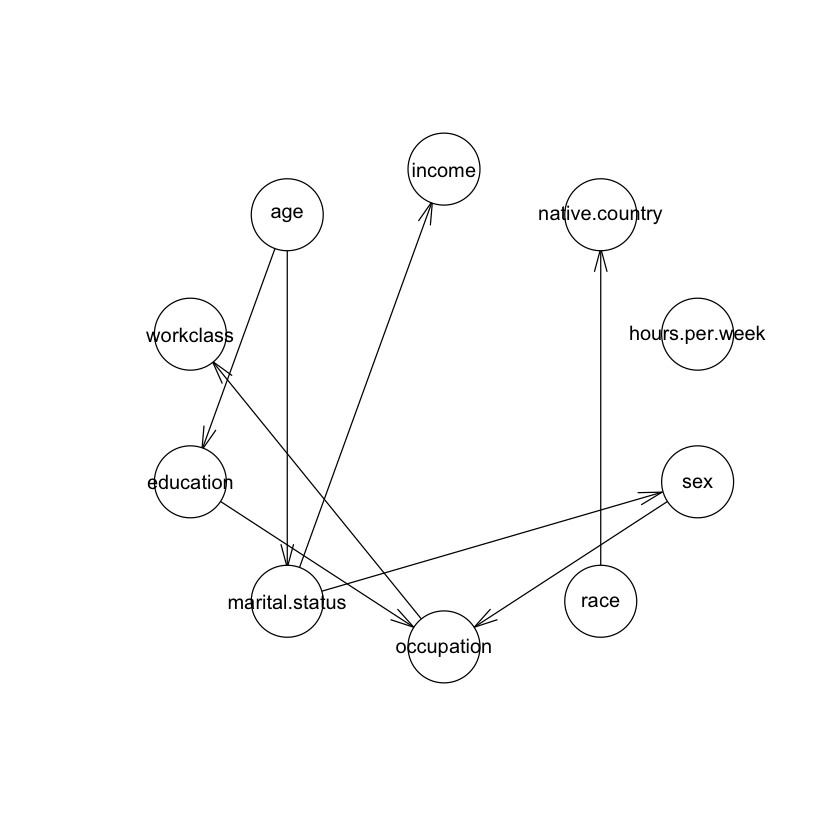

In [73]:
pdag = mmhc(d)
plot(pdag)
pdag

In [55]:
fit = bn.fit(pdag, d)
fit


  Bayesian network parameters

  Parameters of node age (ordinal distribution)

Conditional probability table:
           0           1           2           3           4           5 
0.066242292 0.251939527 0.270638552 0.222465354 0.128837610 0.047145415 
          6           7 
0.010244679 0.002486573 

  Parameters of node workclass (multinomial distribution)

Conditional probability table:
 
         occupation
workclass            0            1            2            3            4
        0 0.7053027356 0.8054910669 0.7568723274 0.5581971273 0.0000000000
        1 0.0560093349 0.1131523165 0.0417430259 0.0903912828 0.0000000000
        2 0.0535459614 0.0189764813 0.0071268581 0.0388806340 0.0000000000
        3 0.0641773629 0.0132229737 0.0258603136 0.0413571075 1.0000000000
        4 0.0639180604 0.0347229232 0.1081246182 0.1713719663 0.0000000000
        5 0.0566575911 0.0134248511 0.0600692323 0.0998018821 0.0000000000
        6 0.0003889537 0.0010093873 0.0002036245 0.00

In [71]:
bnlearn::score(pdag,d,type = "bic")

[1] -273283.7

Warning message in check.score(score, x):
“no score is available for ordinal data, disregarding the ordering of the levels.”


  Bayesian network learned via Score-based methods

  model:
   [age][marital.status|age][race|marital.status][income|age:marital.status]
   [education|age:income][hours.per.week|age:income]
   [sex|marital.status:hours.per.week][native.country|education:race]
   [occupation|education:sex:income][workclass|occupation:sex]
  nodes:                                 10 
  arcs:                                  17 
    undirected arcs:                     0 
    directed arcs:                       17 
  average markov blanket size:           4.20 
  average neighbourhood size:            3.40 
  average branching factor:              1.70 

  learning algorithm:                    Hill-Climbing 
  score:                                 BIC (disc.) 
  penalization coefficient:              5.157169 
  tests used in the learning procedure:  216 
  optimized:                             TRUE 


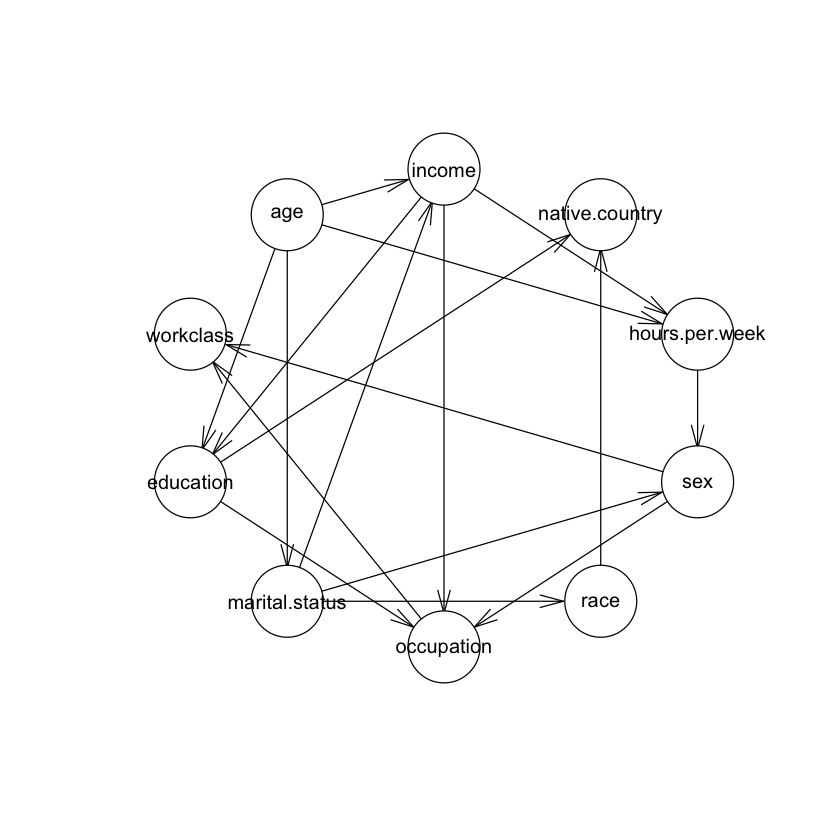

In [74]:
pdag = hc(d)
plot(pdag)
pdag

In [75]:
bnlearn::score(pdag,d,type = "bic")

[1] -267826.3

In [76]:
#TODO check scores - maybe they could work as metrics? 